In [1]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Libraries
from scipy.stats import zscore

# Anomaly Detection Models
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# Performance Evaluation
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

# Visualization
import plotly.express as px
from sklearn.decomposition import PCA


In [2]:
df = pd.read_csv('dataset.csv')
df.head()

,Longitude,Latitude,Speed,Distance,Time,Acc X,Acc Y,Acc Z,Heading,gyro_x,gyro_y,gyro_z,label
0,73.822661,18.501627,0.0,0.0,18-45-12,0.046402,-0.137178,-0.282934,352,-0.036306,-0.008226,-0.023416,0
1,73.822661,18.501627,0.0,0.0,18-45-12,-0.136978,0.365242,0.108889,352,0.035776,-0.009448,0.009570,0
2,73.822661,18.501627,0.0,0.0,18-45-13,-0.045355,-0.103340,-0.534985,352,-0.011871,-0.027774,0.003462,0
3,73.822661,18.501627,0.0,0.0,18-45-13,0.242089,0.072761,-0.350396,352,-0.017980,0.002769,-0.005091,0
4,73.822661,18.501627,0.0,0.0,18-45-13,-0.230234,0.011765,-0.494085,352,0.011342,0.003380,0.006516,0


In [5]:
#Feature Engineering
#Capture how speed fluctuates
df['speed_change'] = df['Speed'].diff()

#Speed Threshold
speed_mean = df['Speed'].mean()
speed_std = df['Speed'].std()
threshold = speed_mean + (3 * speed_std)  # Flags speeds 3 standard deviations above mean

#Flag sudden accelerations or decelerations beyond a certain threshold.
df['speed_anomaly'] = df['speed_change'].apply(lambda x: 1 if abs(x) > threshold else 0)

#Gyroscope Magnitude- Large changes in the gyroscope readings may indicate unusual movements
df['gyro_magnitude'] = (df['gyro_x']**2 + df['gyro_y']**2 + df['gyro_z']**2)**0.54
df.head()

,Longitude,Latitude,Speed,Distance,Time,Acc X,Acc Y,Acc Z,Heading,gyro_x,gyro_y,gyro_z,label,speed_change,speed_anomaly,gyro_magnitude
0,73.822661,18.501627,0.0,0.0,18-45-12,0.046402,-0.137178,-0.282934,352,-0.036306,-0.008226,-0.023416,0,NaN,0,0.034253
1,73.822661,18.501627,0.0,0.0,18-45-12,-0.136978,0.365242,0.108889,352,0.035776,-0.009448,0.009570,0,0.0,0,0.029436
2,73.822661,18.501627,0.0,0.0,18-45-13,-0.045355,-0.103340,-0.534985,352,-0.011871,-0.027774,0.003462,0,0.0,0,0.022990
3,73.822661,18.501627,0.0,0.0,18-45-13,0.242089,0.072761,-0.350396,352,-0.017980,0.002769,-0.005091,0,0.0,0,0.013751
4,73.822661,18.501627,0.0,0.0,18-45-13,-0.230234,0.011765,-0.494085,352,0.011342,0.003380,0.006516,0,0.0,0,0.009574


In [7]:
#Task 1- EDA and Time-based Features
# Exploratory Data Analysis (EDA) and Data Preprocessing
# Check for missing values and data types
print("Dataset Information:")
print(df.info())

# Drop or fill missing values as required (example: forward fill missing data)
df.ffill()

# Statistical summary
print("\nSummary Statistics:")
print(df.describe())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14249 entries, 0 to 14248
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Longitude       14249 non-null  float64
 1   Latitude        14249 non-null  float64
 2   Speed           14249 non-null  float64
 3   Distance        14249 non-null  float64
 4   Time            14249 non-null  object 
 5   Acc X           14249 non-null  float64
 6   Acc Y           14249 non-null  float64
 7   Acc Z           14249 non-null  float64
 8   Heading         14249 non-null  int64  
 9   gyro_x          14249 non-null  float64
 10  gyro_y          14249 non-null  float64
 11  gyro_z          14249 non-null  float64
 12  label           14249 non-null  int64  
 13  speed_change    14248 non-null  float64
 14  speed_anomaly   14249 non-null  int64  
 15  gyro_magnitude  14249 non-null  float64
dtypes: float64(12), int64(3), object(1)
memory usage: 1.7+ 

In [16]:
# A rolling average of speed over a specific time window
df['rolling_avg_speed'] = df['Speed'].rolling(window=10).mean()
# Rolling average of Acc X over a window of 5 readings
df['Rolling_Mean_AccX'] = df['Acc X'].rolling(window=5).mean()

#new features (e.g., speed changes, sudden stops, direction changes).
#Calculate Speed Change & Direction Change
# Speed change (difference between consecutive rows)
df['Speed_Change'] = df['Speed'].diff()

# Direction change (Heading difference)
df['Direction_Change'] = df['Heading'].diff().fillna(0)

# Convert Time column to a proper datetime format
df['Time'] = pd.to_datetime(df['Time'], format='%H-%M-%S')
df['Time_Change'] = (df['Time'].diff().dt.total_seconds()).fillna(0)
# Acceleration Rate and Braking Intensity
df['Acceleration_Rate'] = df['Speed_Change'] / df['Time_Change']
df['Braking_Intensity'] = df['Acceleration_Rate'].apply(lambda x: x if x < 0 else 0)


#Jerk (Rate of Change of Acceleration)
df['Acc_Magnitude'] = np.sqrt(df['Acc X']**2 + df['Acc Y']**2 + df['Acc Z']**2)
df['Jerk'] = df['Acc_Magnitude'].diff() / df['Time_Change']

# Cumulative Distance and Speed Variance
df['Cumulative_Distance'] = df['Distance'].cumsum()
df['Speed_Variance'] = df['Speed'].rolling(window=5).var()


# Moving variance of gyro_x
df['Variance_GyroX'] = df['gyro_x'].rolling(window=5).var()

# Total Acceleration from X, Y, Z components
df['Total_Acc'] = np.sqrt(df['Acc X']**2 + df['Acc Y']**2 + df['Acc Z']**2)

df.head()

,Longitude,Latitude,Speed,Distance,Time,Acc X,Acc Y,Acc Z,Heading,gyro_x,...,Total_Acc,Speed_Change,Direction_Change,Time_Change,Acceleration_Rate,Braking_Intensity,Acc_Magnitude,Jerk,Cumulative_Distance,Speed_Variance
0,73.822661,18.501627,0.0,0.0,1900-01-01 18:45:12,0.046402,-0.137178,-0.282934,352,-0.036306,...,0.317840,NaN,0.0,0.0,NaN,0.0,0.317840,NaN,0.0,NaN
1,73.822661,18.501627,0.0,0.0,1900-01-01 18:45:12,-0.136978,0.365242,0.108889,352,0.035776,...,0.404996,0.0,0.0,0.0,NaN,0.0,0.404996,inf,0.0,NaN
2,73.822661,18.501627,0.0,0.0,1900-01-01 18:45:13,-0.045355,-0.103340,-0.534985,352,-0.011871,...,0.546759,0.0,0.0,1.0,0.0,0.0,0.546759,0.141763,0.0,NaN
3,73.822661,18.501627,0.0,0.0,1900-01-01 18:45:13,0.242089,0.072761,-0.350396,352,-0.017980,...,0.432064,0.0,0.0,0.0,NaN,0.0,0.432064,-inf,0.0,NaN
4,73.822661,18.501627,0.0,0.0,1900-01-01 18:45:13,-0.230234,0.011765,-0.494085,352,0.011342,...,0.545221,0.0,0.0,0.0,NaN,0.0,0.545221,inf,0.0,0.0


In [17]:
# Save the updated dataset
df.to_csv('augmented_dataset.csv', index=False)

In [18]:
#Z-Score-Based Outlier Detection:
# Load the dataset
aug_df = pd.read_csv('augmented_dataset.csv')
print(aug_df.head())

   Longitude   Latitude  Speed  Distance                 Time     Acc X  \
0  73.822661  18.501627    0.0       0.0  1900-01-01 18:45:12  0.046402   
1  73.822661  18.501627    0.0       0.0  1900-01-01 18:45:12 -0.136978   
2  73.822661  18.501627    0.0       0.0  1900-01-01 18:45:13 -0.045355   
3  73.822661  18.501627    0.0       0.0  1900-01-01 18:45:13  0.242089   
4  73.822661  18.501627    0.0       0.0  1900-01-01 18:45:13 -0.230234   

      Acc Y     Acc Z  Heading    gyro_x  ...  Total_Acc  Speed_Change  \
0 -0.137178 -0.282934      352 -0.036306  ...   0.317840           NaN   
1  0.365242  0.108889      352  0.035776  ...   0.404996           0.0   
2 -0.103340 -0.534985      352 -0.011871  ...   0.546759           0.0   
3  0.072761 -0.350396      352 -0.017980  ...   0.432064           0.0   
4  0.011765 -0.494085      352  0.011342  ...   0.545221           0.0   

   Direction_Change  Time_Change  Acceleration_Rate  Braking_Intensity  \
0               0.0          0

In [19]:
# Check for NaN values in the relevant columns
print(aug_df[['Speed', 'Acceleration_Rate', 'Jerk']].isna().sum())

Speed                    0
Acceleration_Rate    11799
Jerk                     9
dtype: int64


In [20]:
#Handle NaN Values for Acceleration_Rate
# Fill NaN values with 0 for Acceleration_Rate
aug_df['Acceleration_Rate'] = aug_df['Acceleration_Rate'].fillna(0)
aug_df = aug_df.dropna(subset=['Acceleration_Rate'])
#Check Again
print(aug_df[['Speed', 'Acceleration_Rate', 'Jerk']].isna().sum())

Speed                0
Acceleration_Rate    0
Jerk                 9
dtype: int64


In [21]:
aug_df['Jerk'] = aug_df['Jerk'].fillna(0)
#Check Again
print(aug_df[['Speed', 'Acceleration_Rate', 'Jerk']].isna().sum())

Speed                0
Acceleration_Rate    0
Jerk                 0
dtype: int64


In [23]:
# Calculate Z-scores for the relevant columns
z_scores = aug_df[['Speed', 'Acceleration_Rate', 'Jerk']].apply(zscore)
# Flag anomalies where Z-score > 3 or < -3
aug_df['Anomaly'] = (np.abs(z_scores) > 3).any(axis=1).astype(int)
# Save the updated dataset
aug_df.to_csv('augmented_dataset.csv', index=False)

# Display anomalies if needed
anomalies = aug_df[aug_df['Anomaly'] == 1]
print(anomalies)

Empty DataFrame
Columns: [Longitude, Latitude, Speed, Distance, Time, Acc X, Acc Y, Acc Z, Heading, gyro_x, gyro_y, gyro_z, label, speed_change, speed_anomaly, gyro_magnitude, rolling_avg_speed, Rolling_Mean_AccX, Variance_GyroX, Total_Acc, Speed_Change, Direction_Change, Time_Change, Acceleration_Rate, Braking_Intensity, Acc_Magnitude, Jerk, Cumulative_Distance, Speed_Variance, Anomaly]
Index: []

[0 rows x 30 columns]


C:\Users\P V Saathwi\anaconda3\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\P V Saathwi\anaconda3\Lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
C:\Users\P V Saathwi\anaconda3\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\P V Saathwi\anaconda3\Lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


Z-Score Detection Results:
       Longitude   Latitude  Speed   Distance                Time     Acc X  \
0      73.822661  18.501627    0.0     0.0000 1900-01-01 18:45:12  0.046402   
1      73.822661  18.501627    0.0     0.0000 1900-01-01 18:45:12 -0.136978   
2      73.822661  18.501627    0.0     0.0000 1900-01-01 18:45:13 -0.045355   
3      73.822661  18.501627    0.0     0.0000 1900-01-01 18:45:13  0.242089   
4      73.822661  18.501627    0.0     0.0000 1900-01-01 18:45:13 -0.230234   
...          ...        ...    ...        ...                 ...       ...   
14244  73.822813  18.501587    0.0  2096.5732 1900-01-01 17:27:34 -0.436406   
14245  73.822813  18.501587    0.0  2096.5732 1900-01-01 17:27:34 -0.436406   
14246  73.822813  18.501587    0.0  2096.5732 1900-01-01 17:27:34 -0.436406   
14247  73.822813  18.501587    0.0  2096.5732 1900-01-01 17:27:34 -0.436406   
14248  73.822813  18.501587    0.0  2096.5732 1900-01-01 17:27:35 -0.436406   

          Acc Y     Acc 

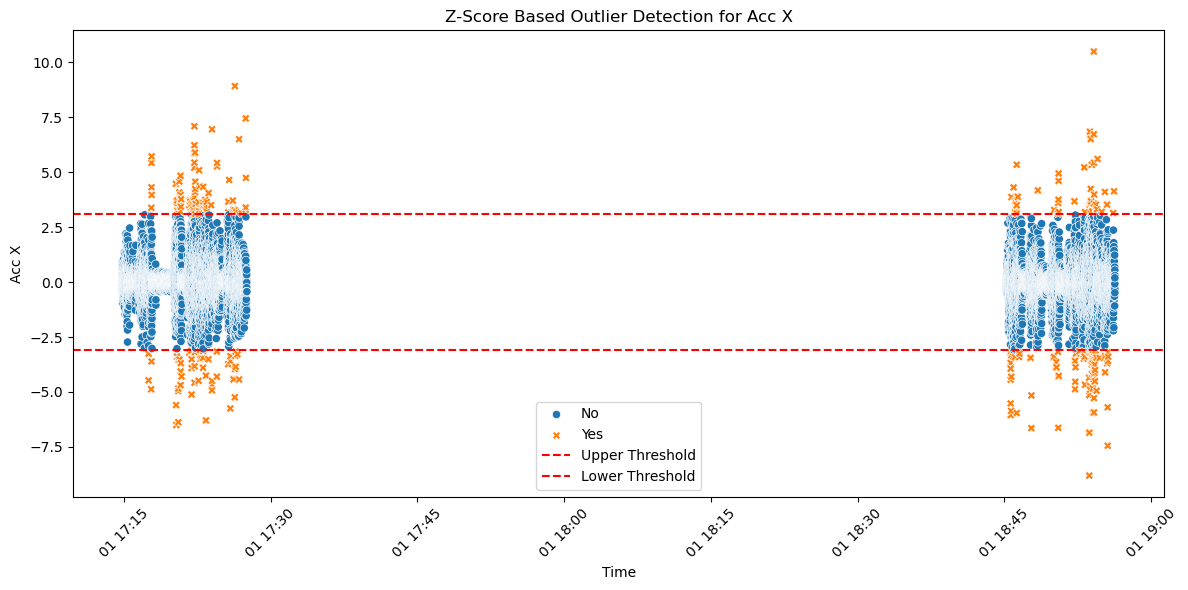

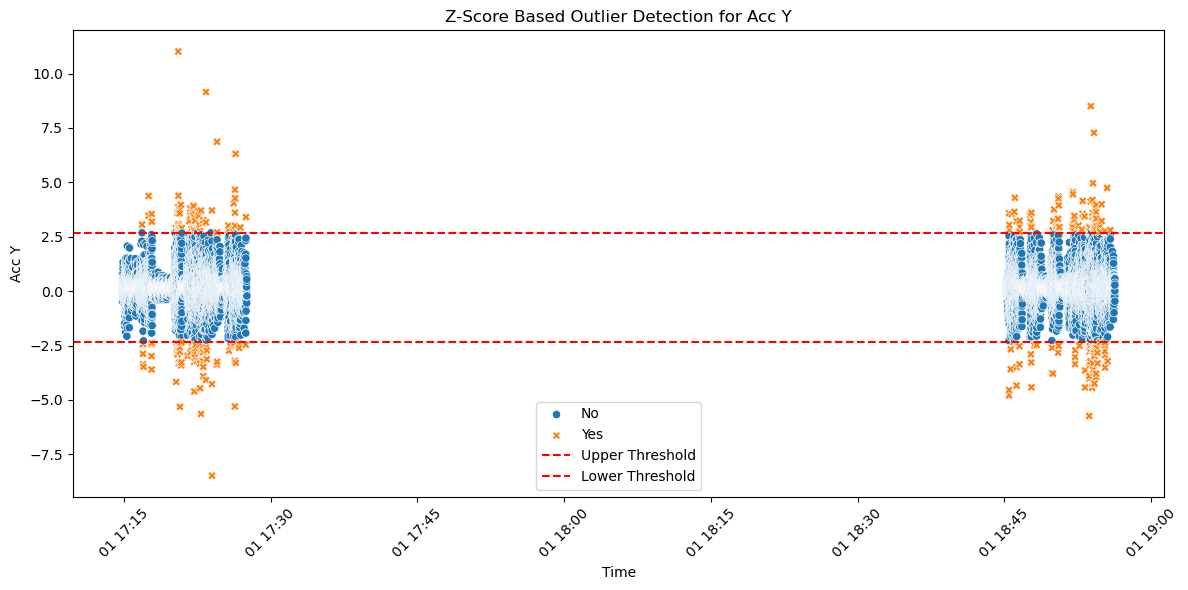

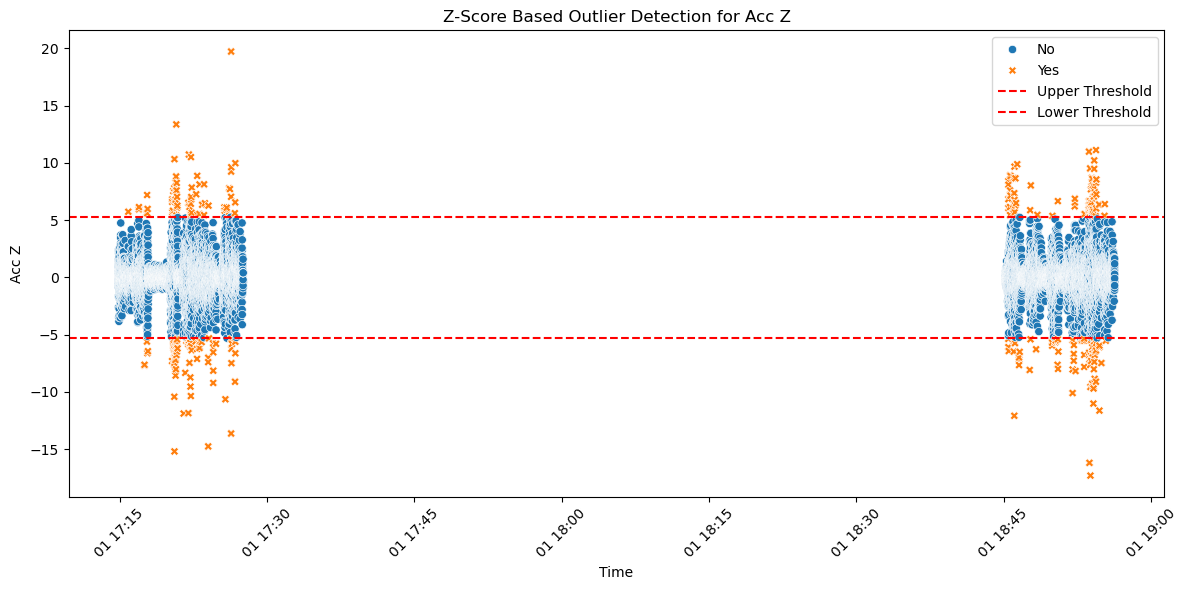

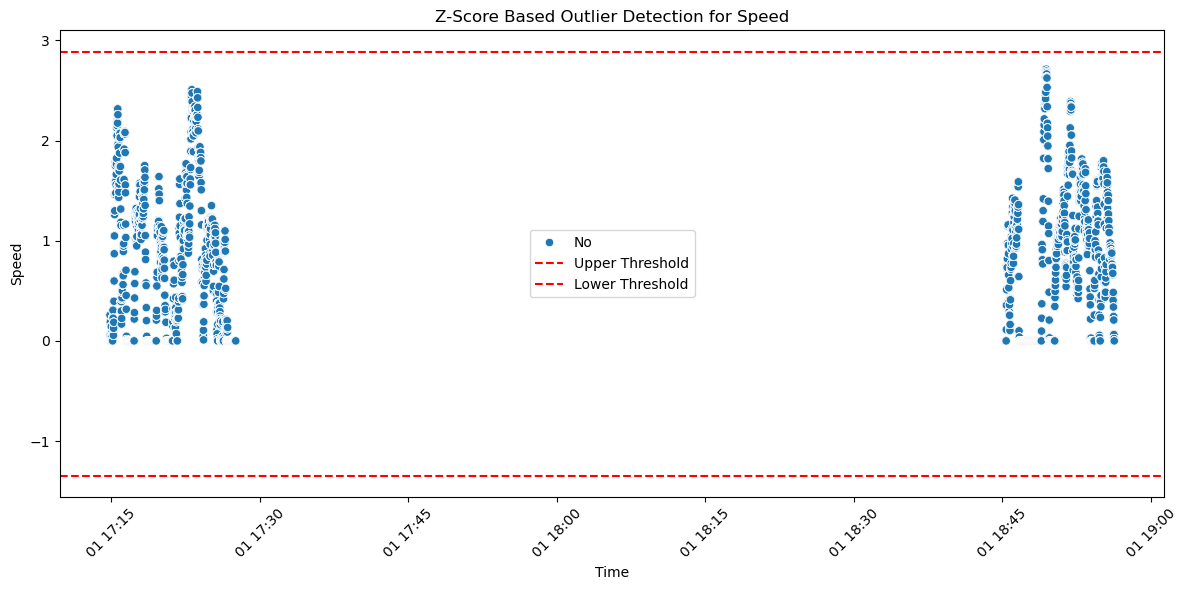

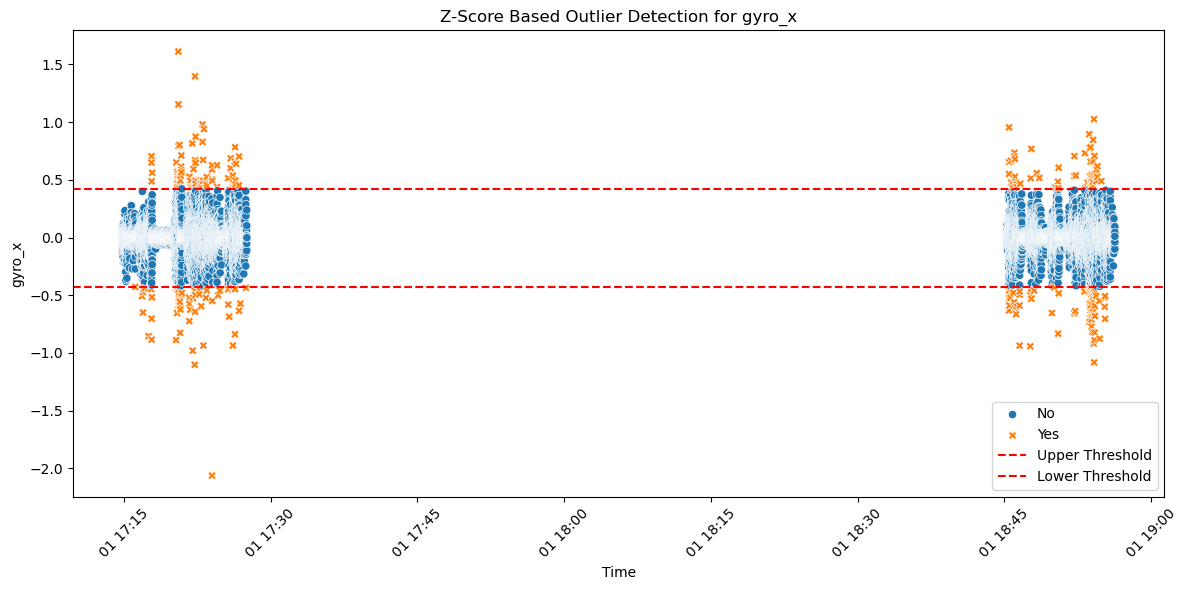

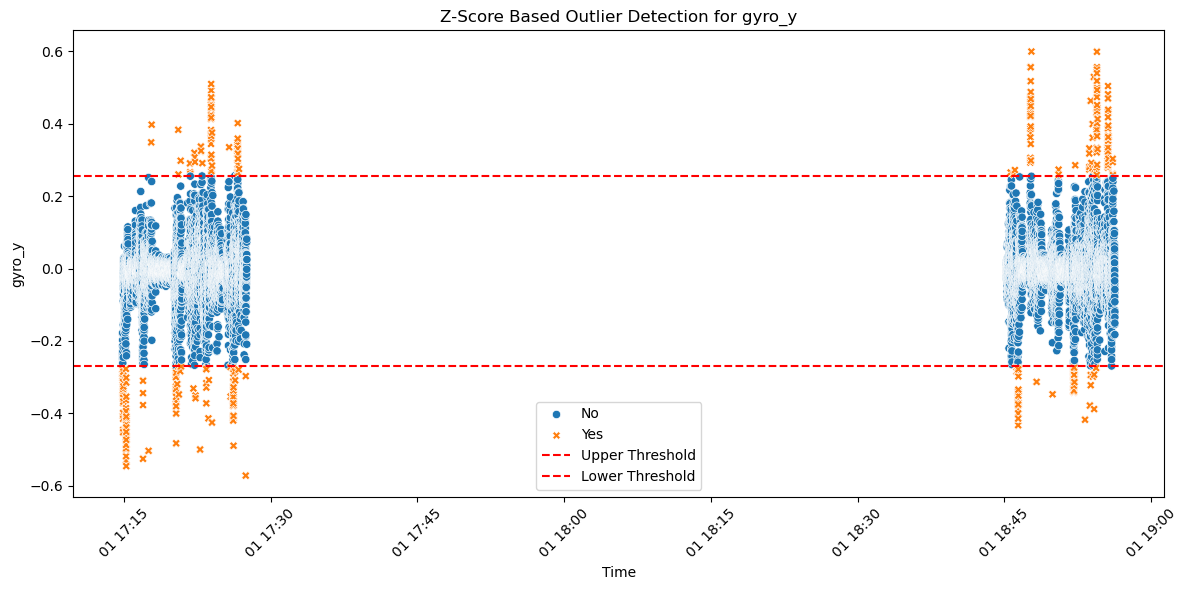

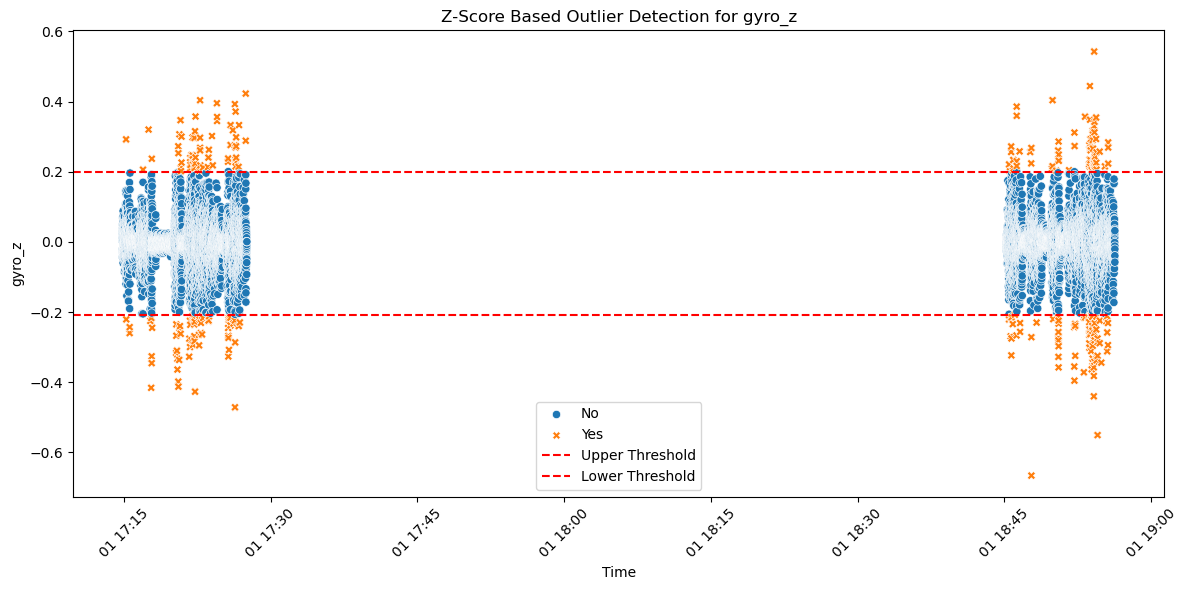

In [24]:

# Define a function for Z-score calculation and anomaly detection
def calculate_z_scores(df, column_name):
    mean = df[column_name].mean()
    std = df[column_name].std()
    z_scores = (df[column_name] - mean) / std          # Z= (X-mean)/sd
    df[f'Z-Score_{column_name}'] = z_scores
    df[f'Anomaly_{column_name}'] = z_scores.apply(lambda x: 'Yes' if abs(x) > 3 else 'No')

# List of parameters for which to calculate Z-scores
parameters = ['Acc X', 'Acc Y', 'Acc Z', 'Speed', 'gyro_x', 'gyro_y', 'gyro_z']

# Calculate Z-scores for each parameter
for param in parameters:
    calculate_z_scores(df, param)

# Display the results
print("Z-Score Detection Results:")
print(df)

# Visualize Z-scores and anomalies for all features
for param in parameters:
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='Time', y=param, hue=f'Anomaly_{param}', style=f'Anomaly_{param}', data=df)
    plt.axhline(y=df[param].mean() + 3 * df[param].std(), color='r', linestyle='--', label='Upper Threshold')
    plt.axhline(y=df[param].mean() - 3 * df[param].std(), color='r', linestyle='--', label='Lower Threshold')
    plt.title(f'Z-Score Based Outlier Detection for {param}')
    plt.xlabel('Time')
    plt.ylabel(param)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Joint Comparison of Z-score and IQR Anomalies:
         Acc X    Acc Y    Acc Z    Speed   gyro_x   gyro_y   gyro_z
0      No | No  No | No  No | No  No | No  No | No  No | No  No | No
1      No | No  No | No  No | No  No | No  No | No  No | No  No | No
2      No | No  No | No  No | No  No | No  No | No  No | No  No | No
3      No | No  No | No  No | No  No | No  No | No  No | No  No | No
4      No | No  No | No  No | No  No | No  No | No  No | No  No | No
...        ...      ...      ...      ...      ...      ...      ...
14244  No | No  No | No  No | No  No | No  No | No  No | No  No | No
14245  No | No  No | No  No | No  No | No  No | No  No | No  No | No
14246  No | No  No | No  No | No  No | No  No | No  No | No  No | No
14247  No | No  No | No  No | No  No | No  No | No  No | No  No | No
14248  No | No  No | No  No | No  No | No  No | No  No | No  No | No

[14249 rows x 7 columns]


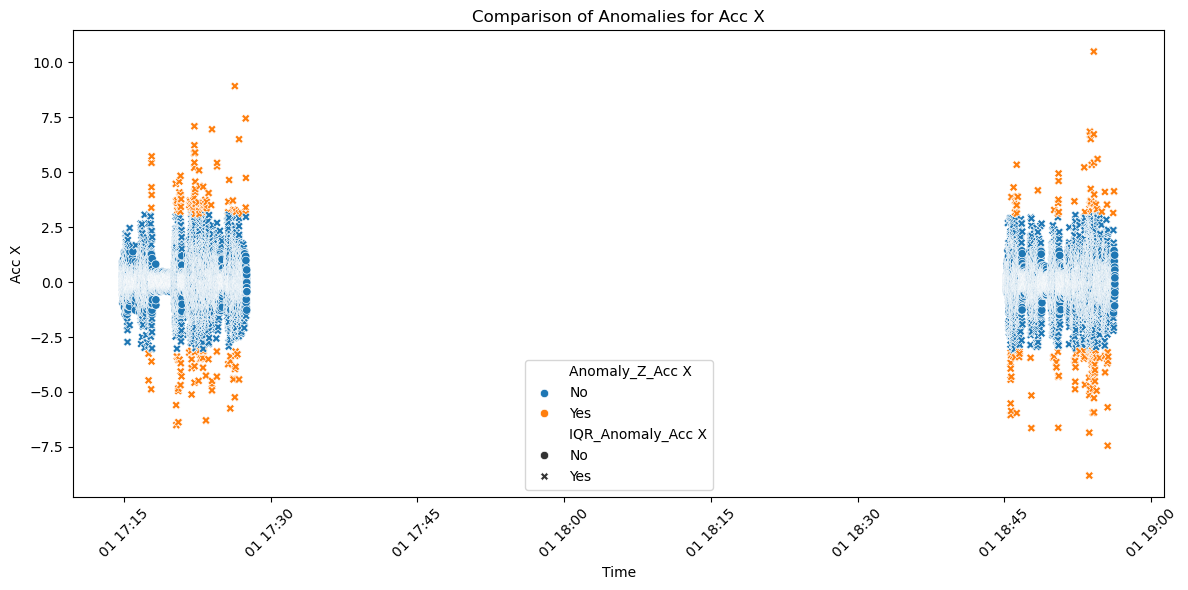

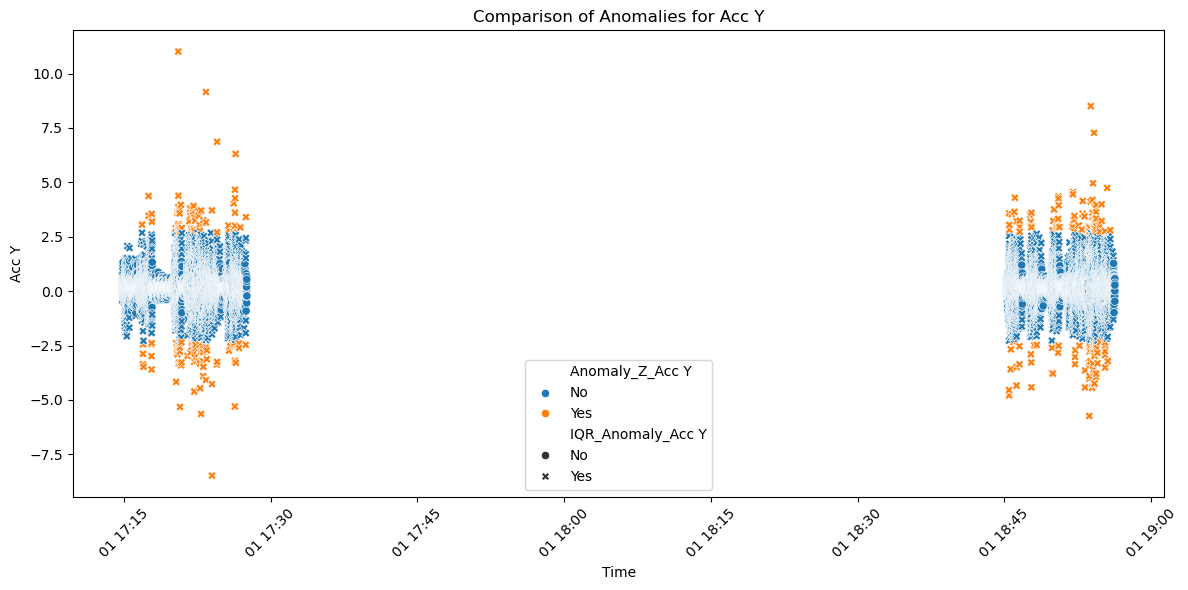

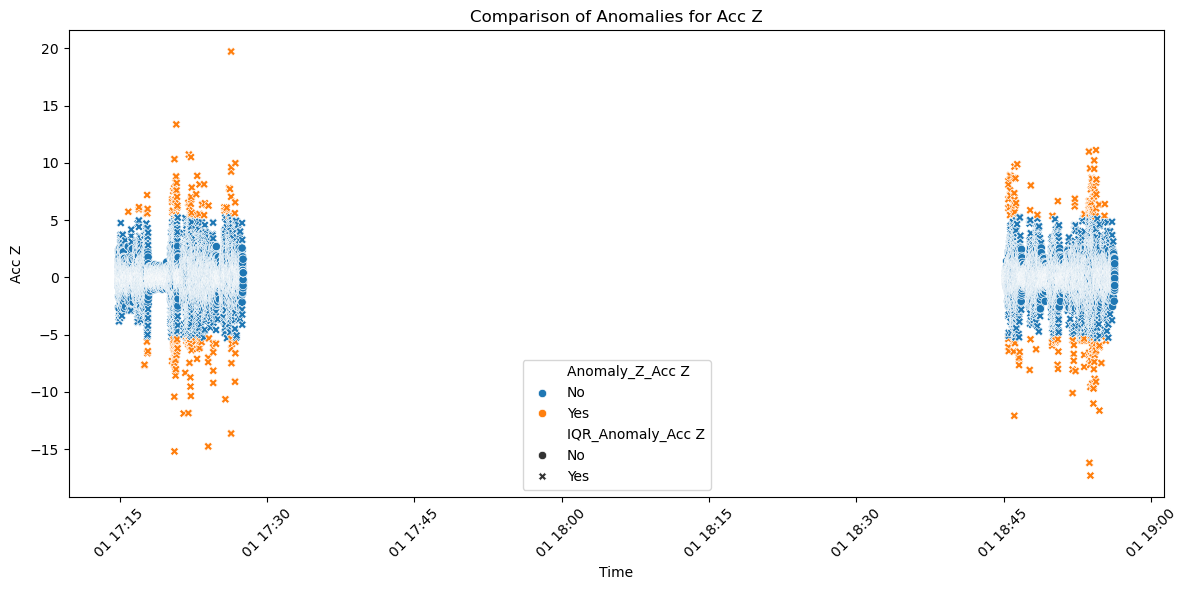

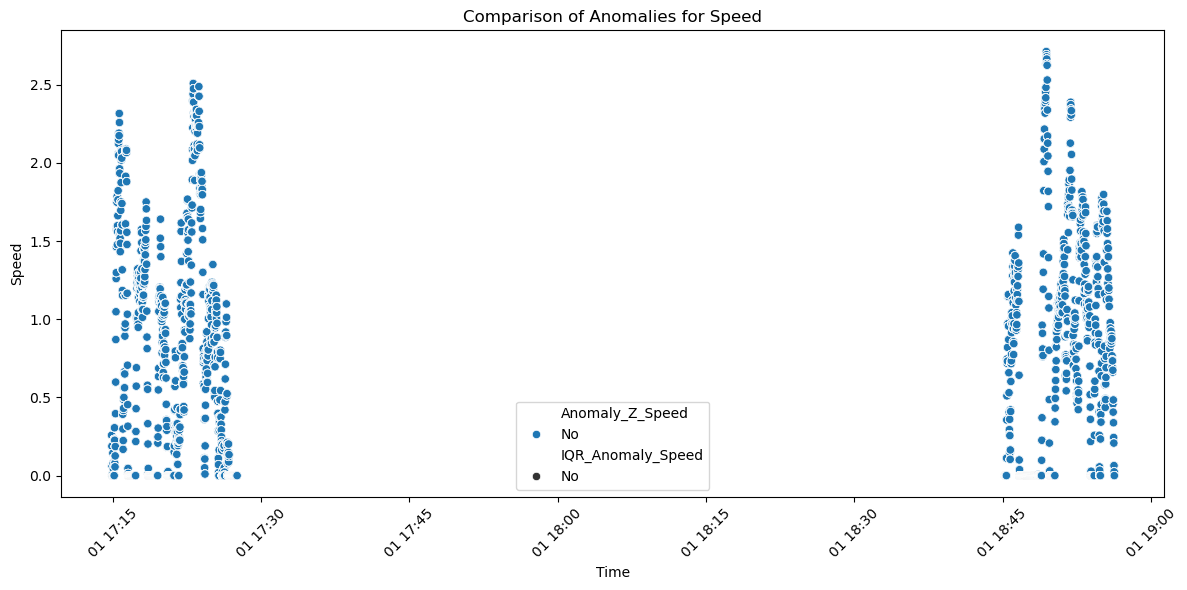

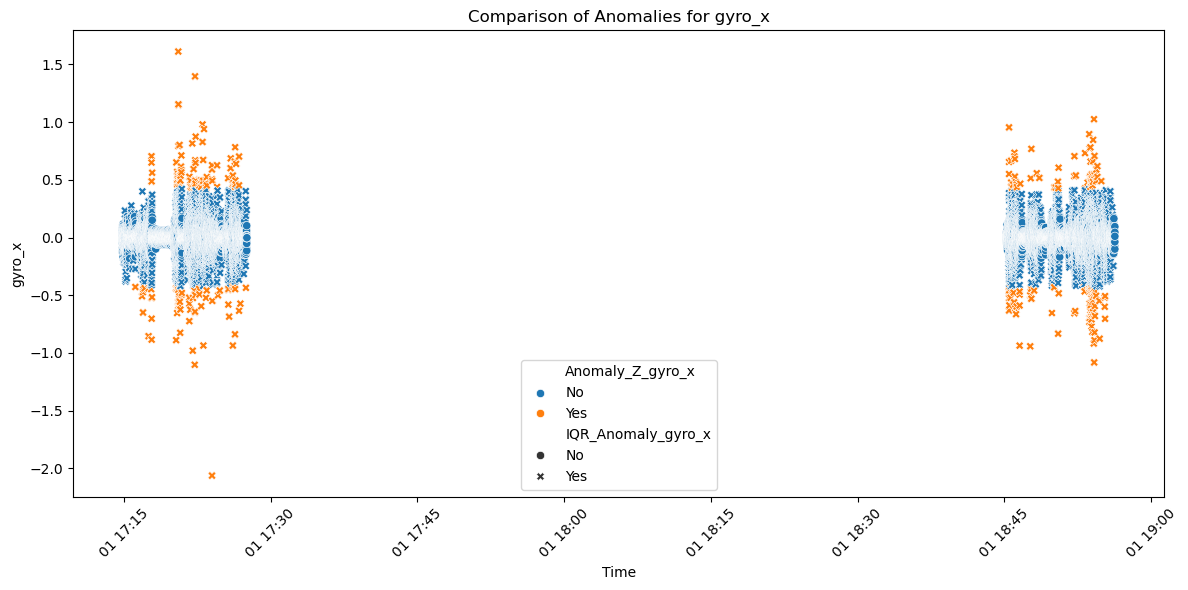

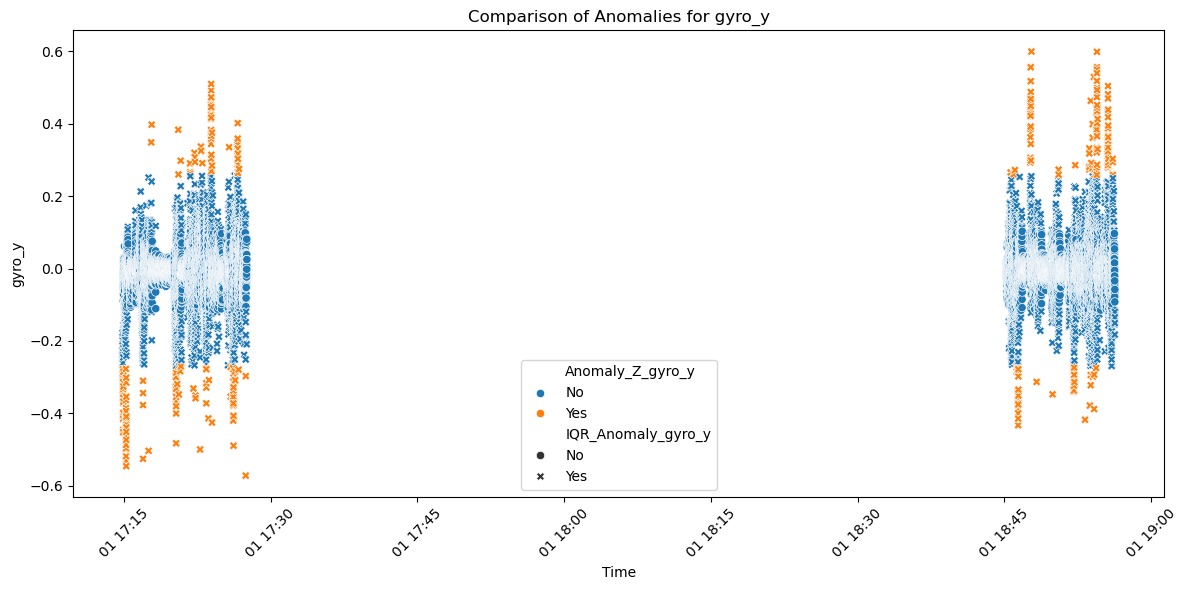

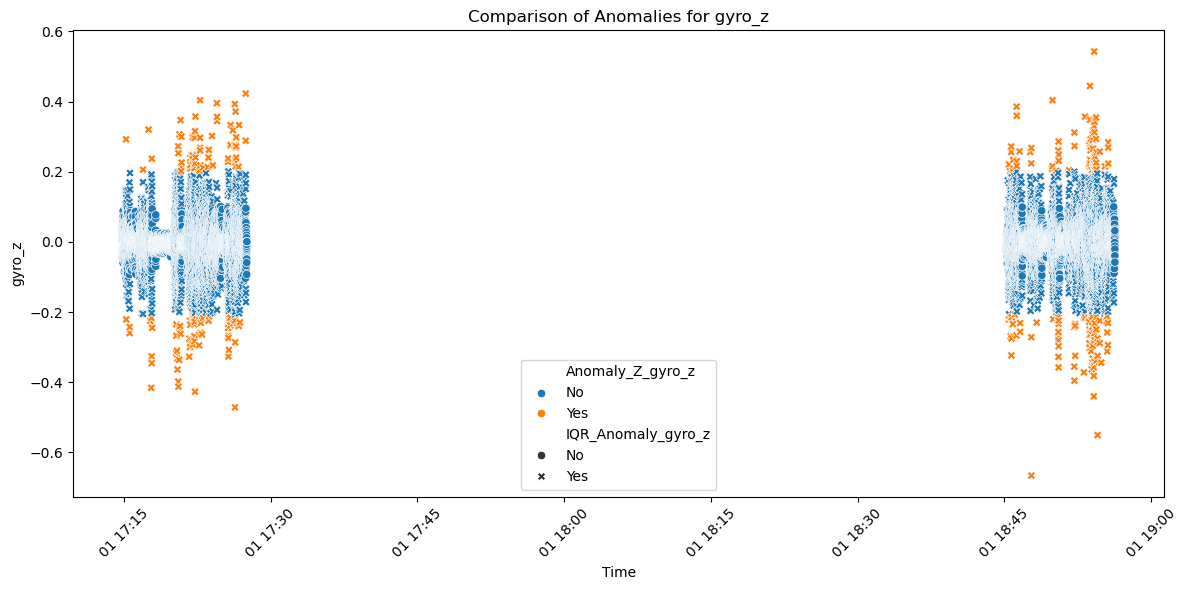

In [25]:
# Define a function for Z-score calculation and anomaly detection
def calculate_z_scores(df, column_name):
    mean = df[column_name].mean()
    std = df[column_name].std()
    z_scores = (df[column_name] - mean) / std
    df[f'Z-Score_{column_name}'] = z_scores
    df[f'Anomaly_Z_{column_name}'] = z_scores.apply(lambda x: 'Yes' if abs(x) > 3 else 'No')

# Define a function for IQR calculation and anomaly detection
def calculate_iqr_anomalies(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[f'IQR_Anomaly_{column_name}'] = df[column_name].apply(
        lambda x: 'Yes' if x < lower_bound or x > upper_bound else 'No'
    )

# List of parameters for which to calculate anomalies
parameters = ['Acc X', 'Acc Y', 'Acc Z', 'Speed', 'gyro_x', 'gyro_y', 'gyro_z']

# Calculate anomalies using Z-scores
for param in parameters:
    calculate_z_scores(df, param)

# Calculate anomalies using IQR
for param in parameters:
    calculate_iqr_anomalies(df, param)

# Compare results
comparison_results = {}
for param in parameters:
    z_anomalies = df[f'Anomaly_Z_{param}']
    iqr_anomalies = df[f'IQR_Anomaly_{param}']

    # Create a combined comparison column
    comparison_results[param] = pd.Series(z_anomalies + " | " + iqr_anomalies)

# Create a summary DataFrame
comparison_df = pd.DataFrame(comparison_results)

# Display the comparison DataFrame
print("Joint Comparison of Z-score and IQR Anomalies:")
print(comparison_df)

# Optional: Visualize results if needed
for param in parameters:
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='Time', y=param, hue=f'Anomaly_Z_{param}', style=f'IQR_Anomaly_{param}', data=df)
    plt.title(f'Comparison of Anomalies for {param}')
    plt.xlabel('Time')
    plt.ylabel(param)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [26]:
from sklearn.ensemble import IsolationForest

# Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
df['iso_forest_anomaly'] = iso_forest.fit_predict(df[['Speed', 'Acc X', 'Acc Y', 'Acc Z', 'gyro_x', 'gyro_y', 'gyro_z', 'gyro_magnitude']])

# Map predictions: -1 -> anomaly, 1 -> normal
df['iso_forest_anomaly'] = df['iso_forest_anomaly'].map({1: 0, -1: 1})  # 1: anomaly, 0: normal
print(df['iso_forest_anomaly'].value_counts())

iso_forest_anomaly
0    12824
1     1425
Name: count, dtype: int64


In [29]:
from sklearn.svm import OneClassSVM

# One-Class SVM
oc_svm = OneClassSVM(kernel='rbf', gamma=0.01, nu=0.1)  # gamma and nu can be tuned
df['svm_anomaly'] = oc_svm.fit_predict(df[['Speed', 'Acc X', 'Acc Y', 'Acc Z', 'gyro_x', 'gyro_y', 'gyro_z', 'gyro_magnitude']])

# Map predictions: -1 -> anomaly, 1 -> normal
df['svm_anomaly'] = df['svm_anomaly'].map({1: 0, -1: 1})  # 1: anomaly, 0: normal
print(df['svm_anomaly'].value_counts())

svm_anomaly
0    12825
1     1424
Name: count, dtype: int64


In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics for Isolation Forest
iso_accuracy = accuracy_score(df['label'], df['iso_forest_anomaly'])
iso_precision = precision_score(df['label'], df['iso_forest_anomaly'])
iso_recall = recall_score(df['label'], df['iso_forest_anomaly'])
iso_f1 = f1_score(df['label'], df['iso_forest_anomaly'])

# Calculate metrics for One-Class SVM
svm_accuracy = accuracy_score(df['label'], df['svm_anomaly'])
svm_precision = precision_score(df['label'], df['svm_anomaly'])
svm_recall = recall_score(df['label'], df['svm_anomaly'])
svm_f1 = f1_score(df['label'], df['svm_anomaly'])

# Combine metrics for plotting
metrics = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Isolation Forest": [iso_accuracy, iso_precision, iso_recall, iso_f1],
    "One-Class SVM": [svm_accuracy, svm_precision, svm_recall, svm_f1]
}

metrics_df = pd.DataFrame(metrics)
print(metrics_df)


      Metric  Isolation Forest  One-Class SVM
0   Accuracy          0.493087       0.496807
1  Precision          0.928421       0.947331
2     Recall          0.156679       0.159758
3   F1-Score          0.268112       0.273409


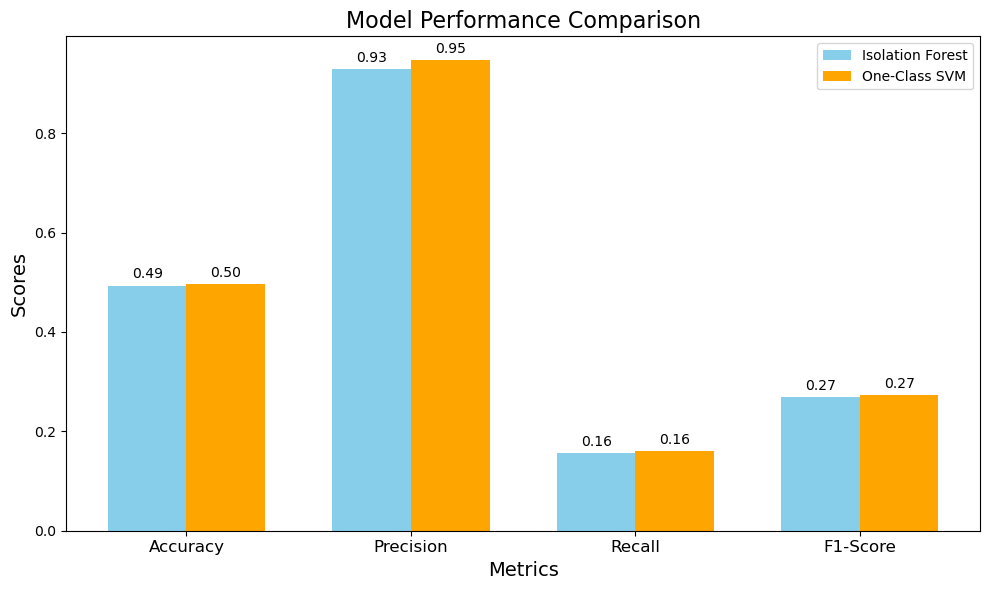

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
x = np.arange(len(metrics["Metric"]))  # the label locations
width = 0.35  # the width of the bars

# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, metrics["Isolation Forest"], width, label='Isolation Forest', color='skyblue')
bars2 = ax.bar(x + width/2, metrics["One-Class SVM"], width, label='One-Class SVM', color='orange')

# Add labels, title, and legend
ax.set_xlabel('Metrics', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Model Performance Comparison', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(metrics["Metric"], fontsize=12)
ax.legend()

# Add value annotations
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()


In [60]:
# Load the dataset
data = pd.read_csv('augmented_dataset.csv')

# Create a true anomaly label if it's not already present
# Assuming the 'Anomaly' column indicates the presence of an anomaly
data['true_anomaly'] = data['Anomaly'].astype(int)
# Feature selection
features = ['Acc X', 'Acc Y', 'Acc Z', 'Speed', 'Acceleration_Rate', 'Total_Acc']
X = data[features]
X.loc[:, 'Acceleration_Rate'] = X['Acceleration_Rate'].replace([np.inf, -np.inf], X['Acceleration_Rate'][np.isfinite(X['Acceleration_Rate'])].max())

In [61]:
#Implement Isolation Forest
from sklearn.ensemble import IsolationForest

# Initialize and fit the Isolation Forest model
iso_forest = IsolationForest(contamination=0.1, random_state=42)
data['iso_forest_anomaly'] = iso_forest.fit_predict(X)

# Convert predictions to binary (1 for anomaly, 0 for normal)
data['iso_forest_anomaly'] = (data['iso_forest_anomaly'] == -1).astype(int)


In [62]:
# Calculate IQR
Q1 = data[['Acc X', 'Acc Y', 'Acc Z', 'Speed']].quantile(0.25)
Q3 = data[['Acc X', 'Acc Y', 'Acc Z', 'Speed']].quantile(0.75)
IQR = Q3 - Q1

# Define upper and lower bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Anomaly detection using IQR
data['IQR_anomaly'] = ((data[['Acc X', 'Acc Y', 'Acc Z', 'Speed']] < lower_bound) |
                        (data[['Acc X', 'Acc Y', 'Acc Z', 'Speed']] > upper_bound)).any(axis=1).astype(int)


In [64]:
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import zscore

# Calculate Z-Scores for each feature and assign to separate columns
data[['Z_Score_Acc_X', 'Z_Score_Acc_Y', 'Z_Score_Acc_Z', 'Z_Score_Speed']] = zscore(data[['Acc X', 'Acc Y', 'Acc Z', 'Speed']], nan_policy='omit')

# Define a threshold for anomalies
threshold = 3

# Anomaly detection based on Z-Score
data['Z_Score_anomaly'] = ((data[['Z_Score_Acc_X', 'Z_Score_Acc_Y', 'Z_Score_Acc_Z', 'Z_Score_Speed']] > threshold).any(axis=1)).astype(int)

# Now that we have the necessary columns, we can perform the comparison
iqr_results = data['IQR_anomaly']
z_score_results = data['Z_Score_anomaly']

# Calculate confusion matrices and classification reports
conf_matrix_iso = confusion_matrix(data['true_anomaly'], data['iso_forest_anomaly'])
conf_matrix_iqr = confusion_matrix(data['true_anomaly'], iqr_results)
conf_matrix_zscore = confusion_matrix(data['true_anomaly'], z_score_results)

class_report_iso = classification_report(data['true_anomaly'], data['iso_forest_anomaly'])
class_report_iqr = classification_report(data['true_anomaly'], iqr_results)
class_report_zscore = classification_report(data['true_anomaly'], z_score_results)

print("Isolation Forest Classification Report:\n", class_report_iso)
print("IQR Classification Report:\n", class_report_iqr)
print("Z-Score Classification Report:\n", class_report_zscore)


Isolation Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95     14249
           1       0.00      0.00      0.00         0

    accuracy                           0.90     14249
   macro avg       0.50      0.45      0.47     14249
weighted avg       1.00      0.90      0.95     14249

IQR Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.77      0.87     14249
           1       0.00      0.00      0.00         0

    accuracy                           0.77     14249
   macro avg       0.50      0.39      0.44     14249
weighted avg       1.00      0.77      0.87     14249

Z-Score Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     14249
           1       0.00      0.00      0.00         0

    accuracy                           0.97     14249
   macro avg       0.50    

C:\Users\P V Saathwi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\Users\P V Saathwi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\Users\P V Saathwi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\Users\P V Saathwi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\Users\P V

In [39]:
!pip install tensorflow
# Import required libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, precision_recall_fscore_support

In [40]:
# Select features for anomaly detection
features = ['Speed', 'Acc X', 'Acc Y', 'Acc Z', 'gyro_x', 'gyro_y', 'gyro_z', 'gyro_magnitude']
X = df[features]
y = df['label']

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Use only normal samples (label = 0) for training
X_train_normal = X_train[y_train == 0]


In [41]:
# Define the autoencoder architecture
input_dim = X_train_normal.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dropout(0.2)(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,288 (20.66 KB)

 Trainable params: 5,288 (20.66 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# Train the model on normal data
history = autoencoder.fit(
    X_train_normal,
    X_train_normal,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


Epoch 1/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0280 - val_loss: 0.0036
Epoch 2/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015 - val_loss: 9.5960e-04
Epoch 4/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013 - val_loss: 8.6359e-04
Epoch 5/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0012 - val_loss: 7.8228e-04
Epoch 6/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0010 - val_loss: 7.3303e-04
Epoch 7/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.9643e-04 - val_loss: 6.6696e-04
Epoch 8/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.9796e-04 - val_loss: 6.1405e-04
Epoch 9/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.2202e-04 - val_loss: 5.7001e-04
Epoch 10/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.4994e-04 - val_loss: 5.4692e-04
Epoch 11/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.3070e-04 - val_loss: 5.3639e

In [47]:
# Ensure reconstructions and X_train_normal are NumPy arrays with the same shape
X_train_normal = X_train_normal.numpy() if hasattr(X_train_normal, 'numpy') else X_train_normal
reconstructions = reconstructions.numpy() if hasattr(reconstructions, 'numpy') else reconstructions

# Check shapes
if X_train_normal.shape != reconstructions.shape:
    raise ValueError(f"Shape mismatch: X_train_normal shape {X_train_normal.shape} vs reconstructions shape {reconstructions.shape}")


In [48]:
from tensorflow.keras.losses import MeanSquaredError

# Instantiate the loss object
mse = MeanSquaredError()

# Compute reconstruction errors
train_errors = np.mean(np.square(X_train_normal - reconstructions), axis=1)

# Set threshold
threshold = np.percentile(train_errors, 95)
print(f"Reconstruction error threshold: {threshold}")


Reconstruction error threshold: 0.0008343991974627415


In [53]:
# Predict on normal training data to get reconstruction errors
reconstructions = autoencoder.predict(X_train_normal)

# Calculate reconstruction errors
train_errors = np.mean(np.square(X_train_normal - reconstructions), axis=1)

# Set the threshold as the 95th percentile of reconstruction error
threshold = np.percentile(train_errors, 95)
print(f"Reconstruction error threshold: {threshold}")

# Predict on test data
test_reconstructions = autoencoder.predict(X_test)

# Calculate test reconstruction errors
test_errors = np.mean(np.square(X_test - test_reconstructions), axis=1)

# Predict anomalies based on the threshold
y_pred = (test_errors > threshold).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Reconstruction error threshold: 0.0008343991974627415
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.96      0.68      1748
           1       0.93      0.40      0.56      2527

    accuracy                           0.63      4275
   macro avg       0.73      0.68      0.62      4275
weighted avg       0.76      0.63      0.61      4275



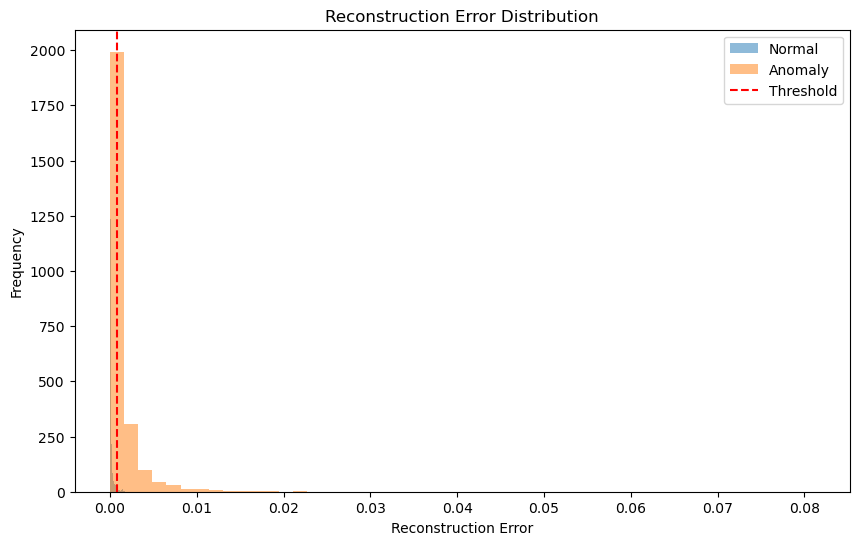

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(test_errors[y_test == 0], bins=50, alpha=0.5, label='Normal')
plt.hist(test_errors[y_test == 1], bins=50, alpha=0.5, label='Anomaly')
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.show()


In [55]:
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1_score:.2f}")


Precision: 0.93
Recall: 0.40
F1-Score: 0.56
